# 2021시즌 KBO 타자 연봉 예측

In [1]:
# 분석 모듈
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

# 크롤링 모듈
from selenium import webdriver
from bs4 import BeautifulSoup
import re

# matplotlib 한글 출력 가능하도록 만들기
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

import os
os.chdir('C:/BigData/SooDa/2021/2021_과제_3')

In [2]:
# 저장해둔 데이터 불러오기
data = pd.read_csv("data_1982_2020.csv", index_col = 0)
income = pd.read_csv("income.csv", index_col = 0)
foreigner = pd.read_csv("foreigner_1982_2020.csv", index_col = 0)

In [3]:
# 연봉 이상치 제거
income.drop(income.loc[income['연봉(만원)']==900000].index, inplace=True)

# 외국인 선수 제거
fore = foreigner['이름'].unique()
for i in range(len(fore)):
    income.drop(income.loc[income['이름'] == fore[i]].index, inplace = True)
    
# 기록 테이블과 연봉 테이블 결합
result = pd.merge(data, income, how = 'left', on = ['이름', '생일', '시즌'])
result = result.dropna()

In [4]:
# Find correlations with the target and sort
correlations = result.corr()['연봉(만원)'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(11))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 타수        0.422855
2타        0.423177
타석        0.427930
병살        0.435307
안타        0.448562
홈런        0.453647
볼넷        0.455607
루타        0.469116
타점        0.499824
연차        0.518046
연봉(만원)    1.000000
Name: 연봉(만원), dtype: float64

Most Negative Correlations:
 ID     -0.418055
희타     -0.037321
3타      0.057644
도루      0.077544
도실      0.089083
시즌      0.210177
타율      0.254680
출루      0.256230
wOBA    0.282141
OPS     0.295634
Name: 연봉(만원), dtype: float64


Text(0.5, 1.0, 'Top 10 correlations with income')

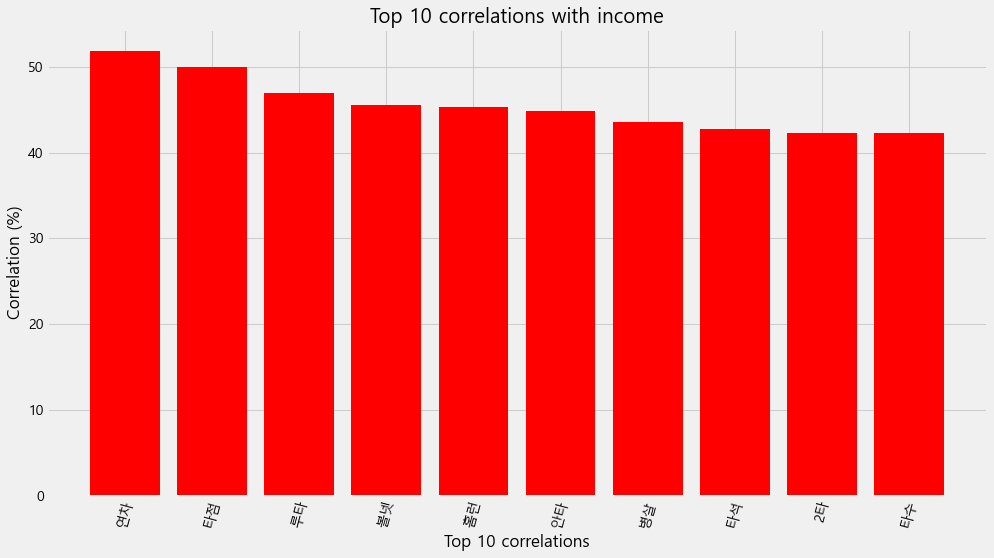

In [5]:
# 상관계수 Top 10 보여주기
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,8))

plt.bar(correlations.tail(11)[:-1].index.astype(str)[::-1], 100*correlations.tail(11)[:-1][::-1],color='r')

# Plot labeling
plt.xticks(rotation=75) ; plt.xlabel('Top 10 correlations'); plt.ylabel('Correlation (%)');
plt.title('Top 10 correlations with income')

Text(0.5, 1.0, 'Low 8 correlations with income')

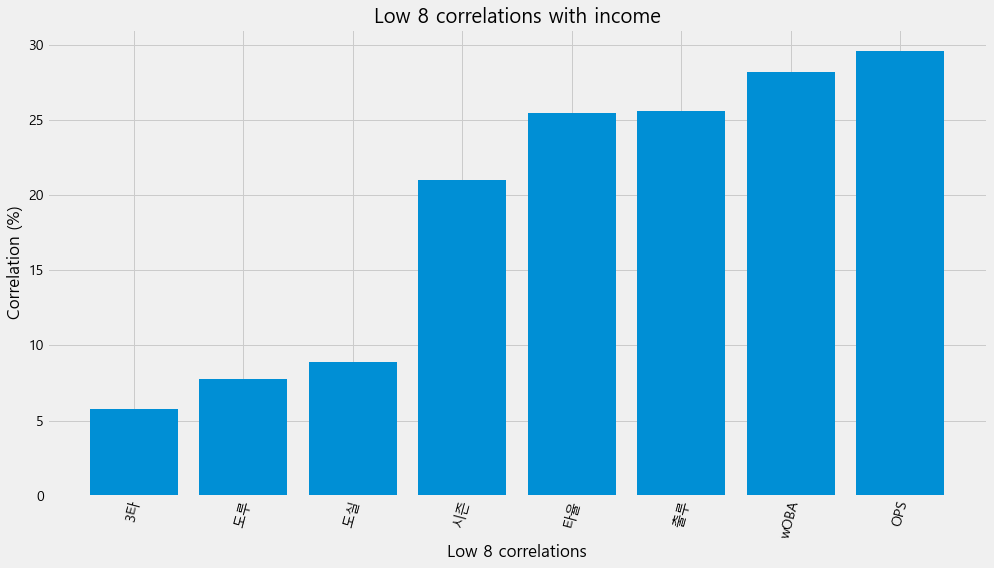

In [6]:
# 상관계수 Low 8 보여주기
plt.figure(figsize=(15,8))

plt.bar(correlations.head(10)[2:].index.astype(str), 100*correlations.head(10)[2:])

# Plot labeling
plt.xticks(rotation=75) ; plt.xlabel('Low 8 correlations'); plt.ylabel('Correlation (%)')
plt.title('Low 8 correlations with income')

### Feature Engineering

In [7]:
# 1루타 feature 생성
result['1타'] = result['안타'] - result['2타'] - result['3타'] - result['홈런']

In [8]:
# 사용할 features 명시
infos = ['ID','이름','생일','팀','시즌','포지션','나이','연차']
stats = ['G','타수','득점','안타','1타','2타','3타','홈런','루타','타점','도루',
         '도실','볼넷','사구','고4','삼진','병살','희타','희비','타율','출루',
         '장타','OPS','wOBA','wRC+','WAR+','연봉(만원)']

In [9]:
# 해당 시즌 이전까지의 누적 평균 기록
def get_cumulative(player_id, season, stat=stats ,df=result):
    try:
        result_cum = df[(df['ID']==player_id) & (df['시즌'] < season)][stat]
        result_cum = result_cum.mean()
        
    except:
        result_cum = [np.nan for i in stat]
        result_cum = pd.Series(result_cum)
    
    return result_cum

In [10]:
# 모든 stats에 대한 누적 stat
stats_cum = [i + '_누적' for i in stats]

In [11]:
# 누적 stat 데이터프레임에 반영
result[stats_cum] = result.apply(lambda x: get_cumulative(x['ID'], x['시즌']), axis=1)

In [12]:
# lag stat (직전 몇년의 기록)
def get_lag(player_id, season, lag, stat=stats, df=result):
    try:
        result_lag = df[(df['ID']==player_id)&(df['시즌'] == season-lag)][stat].values[0]
        result_lag = pd.Series(result_lag)
        
    except:
        result_lag = [np.nan for i in stat]
        result_lag = pd.Series(result_lag)
        
    return result_lag

In [13]:
# 직전 1,2,3년의 기록
stats_lag1 = [i + '_LAG1' for i in stats]
stats_lag2 = [i + '_LAG2' for i in stats]
stats_lag3 = [i + '_LAG3' for i in stats]

In [14]:
# lag1
result[stats_lag1] = result.apply(lambda x: get_lag(x['ID'],x['시즌'], lag=1), axis=1)

In [15]:
# lag2
result[stats_lag2] = result.apply(lambda x: get_lag(x['ID'],x['시즌'], lag=2), axis=1)

In [16]:
# lag3
result[stats_lag3] = result.apply(lambda x: get_lag(x['ID'],x['시즌'], lag=3), axis=1)

In [17]:
# 내년 기록 
# 데이터 프레임의 정답 셋 만들기 위함

def get_next_year(player_id, season, stat=['연봉(만원)'], df=result):
    try:
        result = df[(df['ID']==player_id)&(df['시즌']==season+1)][stat].values[0]
        result = pd.Series(result)
    except:
        result = [np.nan for i in stat]
        result = pd.Series(result)
        
    return result

In [18]:
# 내년 기록
stats_next = [i + '_NEXT' for i in ['연봉(만원)']]
result[stats_next] = result.apply(lambda x: get_next_year(x['ID'], x['시즌']), axis=1)

In [19]:
result

,ID,이름,생일,팀,시즌,포지션,나이,G,타석,타수,...,희비_LAG3,타율_LAG3,출루_LAG3,장타_LAG3,OPS_LAG3,wOBA_LAG3,wRC+_LAG3,WAR+_LAG3,연봉(만원)_LAG3,연봉(만원)_NEXT
2,2,심정수,1975-05-05,현,2003,RF,29,133.0,601.0,460.0,...,9.0,0.304,0.400,0.551,0.951,0.413,149.9,5.31,10000.0,60000.0
5,3,이승엽,1976-08-18,삼,2002,1B,27,133.0,617.0,511.0,...,4.0,0.323,0.458,0.733,1.190,0.486,191.8,8.91,11000.0,63000.0
6,3,이승엽,1976-08-18,삼,1999,1B,24,132.0,614.0,486.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30000.0
7,4,이대호,1982-06-21,롯,2010,3B,29,127.0,552.0,478.0,...,5.0,0.335,0.453,0.600,1.053,0.461,194.2,7.00,32000.0,63000.0
11,3,이승엽,1976-08-18,삼,2003,1B,28,131.0,596.0,479.0,...,3.0,0.293,0.404,0.604,1.008,0.428,157.3,5.18,30000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6722,406,강성우,1970-01-05,롯,1997,DH,28,79.0,191.0,171.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4500.0
6723,514,강한울,1991-09-12,K,2015,SS,25,90.0,292.0,264.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000.0
6726,483,조동화,1981-03-22,S,2009,RF,29,102.0,191.0,169.0,...,2.0,0.201,0.266,0.281,0.547,0.246,45.7,-0.22,4500.0,9000.0
6727,836,김영진,1972-04-09,삼,1999,C,28,97.0,212.0,189.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# 출력 할 때 마다, 기존 출력물들은 제거해주는 모듈
from IPython.display import clear_output

# 모델 모듈
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [21]:
df = result.fillna(-1) # nan값 -1로 impute 
df = df[df['연봉(만원)_NEXT'] > 0] # 다음 해의 OPS가 존재하는 값들만 추출 (다음 해 OPS 가 없다면, predict 값과 target값을 비교 할 수 없기 때문)

In [22]:
# 포지션 dummy variable로 변환
df = pd.concat([df, pd.get_dummies(df['포지션'], drop_first=True)], axis=1) 

In [23]:
# 사용 features 명시
infos = ['ID','이름','생일','팀','시즌','포지션','나이','연차']
stats = ['G','타수','득점','안타','1타','2타','3타','홈런',
         '루타','타점','도루','도실','볼넷','사구','고4','삼진',
         '병살','희타','희비','타율','출루','장타','OPS','연봉(만원)']

In [24]:
# 누적 및 lag stat features 이름
stats_cum = [i + '_누적' for i in stats]
stats_lag1 = [i + '_LAG1' for i in stats]
stats_lag2 = [i + '_LAG2' for i in stats]
stats_lag3 = [i + '_LAG3' for i in stats]

In [25]:
# X features와 y feature 정리
stats_position = ['C', '2B', '3B', 'SS', 'LF', 'CF', 'RF', 'DH']
X_cols = stats + stats_cum + stats_lag1 + stats_lag2 + stats_position + ['나이', '연차']
y_cols = ['연봉(만원)_NEXT']

In [26]:
# 학습시킬 모델
model_dict = {'xgb':XGBRegressor(n_estimators=110, learning_rate=0.05 ,max_depth=3, min_samples_split=400, random_state=23),
              'lgbm':LGBMRegressor(),
              'rf':RandomForestRegressor(),
              'svr':SVR(),
              'knn':KNeighborsRegressor(),
              'reg':LinearRegression(),
              'ridge':Ridge(),
              'lasso':Lasso()}

In [27]:
test_error = []
r2 = []

for year in range(2000, 2021):

    train = df[df['시즌'] < year-1].reset_index(drop=True)
    test = df[df['시즌'] == year-1].reset_index(drop=True)
    
    X_train = train[X_cols]
    y_train = train[y_cols]

    X_test = test[X_cols]
    y_test = test[y_cols]
    
    model = model_dict['xgb']    #모델명 바꾸어 가면서 실험 가능
    weight = train['타수']
    model.fit(X_train, y_train, sample_weight=weight)
    y_predict = model.predict(X_test)
    
    test_error.append(mean_squared_error(y_test, y_predict, sample_weight=X_test['타수']) ** 0.5)
    r2.append(r2_score(y_test, y_predict))
    
    clear_output(wait=True)
    print(year, ": 완료")
    
    
print("test error : ", np.mean(test_error))
print("test std : ", np.std(test_error))
print("r2 : ", np.mean(r2))
print("완료")

2020 : 완료
test error :  8642.6583285274
test std :  5103.210021693561
r2 :  0.8308707577771498
완료


In [28]:
test_error = []
r2 = []

for year in range(2000, 2021):

    train = df[df['시즌'] < year-1].reset_index(drop=True)
    test = df[df['시즌'] == year-1].reset_index(drop=True)
    
    X_train = train[X_cols]
    y_train = train[y_cols]

    X_test = test[X_cols]
    y_test = test[y_cols]
    
    model = model_dict['ridge']    #모델명 바꾸어 가면서 실험 가능
    weight = train['타수']
    model.fit(X_train, y_train, sample_weight=weight)
    y_predict = model.predict(X_test)
    
    test_error.append(mean_squared_error(y_test, y_predict, sample_weight=X_test['타수']) ** 0.5)
    r2.append(r2_score(y_test, y_predict))
    
    clear_output(wait=True)
    print(year, ": 완료")
    
    
print("test error : ", np.mean(test_error))
print("test std : ", np.std(test_error))
print("r2 : ", np.mean(r2))
print("완료")

2020 : 완료
test error :  7325.945462095899
test std :  4295.2650140740025
r2 :  0.8546939236278368
완료


(0.0, 300000.0)

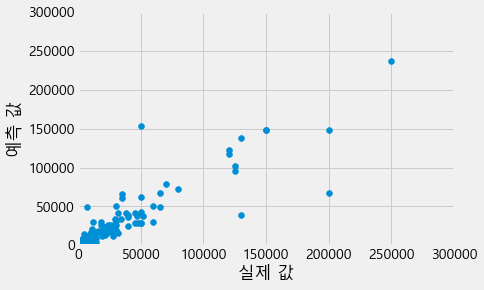

In [29]:
# 예측값과 실제값의 시각화
plt.scatter(y_test, y_predict)
plt.xlabel("실제 값")
plt.ylabel("예측 값")
plt.xlim(0, 300000)
plt.ylim(0, 300000)

In [30]:
predict = result[result['시즌']==2020] # 2020년도 데이터 프레임
predict = pd.concat([predict, pd.get_dummies(predict['포지션'], drop_first=True)], axis=1) # 포지션 dummy variable로 변환

In [31]:
X = predict[X_cols] # 사용 feature
X = X.fillna(-1) # NA값 -1로 impute

# 예측
final = model.predict(X)

In [32]:
predict['연봉(만원)_NEXT'] = final # 예측한 값 채워주기

In [33]:
predict = predict[['이름', '연봉(만원)_NEXT']] # 필요한 column만 추출

In [34]:
predict = predict.reset_index(drop = True) # index 초기화

In [36]:
predict.to_csv("final_result.csv", encoding="cp949")